Provare a indovinare se nel prossimo trimestre avremo o meno una contrazione del mercato è un problema di forecasting binario.
Il modello che vogliamo implementare non deve essere per forza super preciso ma sicuramente deve essere interpretabile.

## Metodo 

Per il nostro scopo andremo a scaricare una serie di indicatori mensili dal 1967 al 2018, etichetteremo questi dati come *Normale* e *Contrazione* usando le indicazioni del **National Bureau of Economic Research**.

I dati macroeconomici sono ottenuti dal Fred e si compongono in varie categorie lavoro, tassi di interesse, credito e mercati azionari.

Useremo l'80% dei dati per il training e il 20% per il test 

### Concetto di regime

Riprendiamo il concetto di regime visto nell'esempio precedente, 

I regimi identificati dai metodi econometrici spesso corrispondono a diversi periodi di regolamentazione, politica e altri cambiamenti secolari.


* Il comportamento dei tassi di interesse è cambiato notevolmente dal 1979 al 1982.
* Nei mercati azionari, diversi regimi corrispondono a periodi di alta e bassa volatilità, e a periodi di mercato rialzista e ribassista.

Come visto la modellazione a regimi possono catturare il comportamento di molte serie finanziarie come ad esempio:

* Code lunghe
* Periodi di turbolenza persistente seguiti da periodi di bassa volatilità
* Asimmetria
* Correlazioni variabili nel tempo

Abbiamo visto che le tecniche di trend filtering, come abbiamo visto il filtro per il valore di $\lambda$ pari a 0 risulta uguale alla serie mentre per $\lambda \to \infty$ tenderanno verso un valore costante

In [1]:
%load_ext autoreload
%autoreload 2

from trendfilter import TrendFilter

In [2]:
filter = TrendFilter()

Carichiamo i dati dell'indice S&P 500 partendo dal 01/01/1959 fino ad oggi e calcoliamo i rendimenti mensili

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

nyears = 50
end_date = datetime.now()
start_date = end_date - timedelta(days=nyears*365)
initial_value = 1

try:
    sp500 = yf.download('^GSPC', start=start_date.strftime('%Y-%m-%d'),end=end_date.strftime('%Y-%m-%d'))
    
    if len(sp500) == 0:
        raise Exception('Empty series')
    
    ret = sp500['Close'].pct_change().dropna()
except:
    print("Error during retrieve index S&P 500")
    
    ret=pd.read_csv('data/sp500.csv',parse_dates =['Date'],usecols=['Date','Close'],index_col=0).pct_change().dropna()

#calc wealth index monthly return
ret = ret.resample('M').apply(lambda x: (x + 1).prod() - 1).to_period('M').to_timestamp()
dates = ret.index
wealth = initial_value * (1 + ret).cumprod()

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['^GSPC']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Error during retrieve index S&P 500


Procediamo poi con il caricamento dei dati provenienti __[dai cicli di mercato analizzati da NBER](http://www.nber.org/cycles.html)__ che ci da la possibilità di analizzare l'inzio e la fine di una recessione della economia degli stati uniti.

I valori 0 indicano un periodo di crescita mentre 1 indica una recessione

In [4]:
df_recession=pd.read_csv('data/recession_dates.csv',parse_dates =['Date'],usecols=['Date','Regime'],index_col=0)
df_recession.value_counts(normalize=True).round(2)

Regime
0         0.87
1         0.13
Name: proportion, dtype: float64

Come si vede abbiamo più periodi di crescita che di recessione (dati sbilanciati) questo va tenuto a mente nella scelta della metrica di errore.

Analizziamo il numero dei periodi di recessione e la distribuzione della durata.

In [5]:
df_recession['group'] = (df_recession['Regime'] != df_recession['Regime'].shift()).cumsum()
df_group = df_recession[df_recession['Regime'] == 1].groupby('group').agg(
    first_date=('Regime', lambda x: x.index.min()),
    last_date=('Regime', lambda x: x.index.max())
).reset_index()

df_group['lenght'] = (df_group['last_date'].dt.to_period('M') - df_group['first_date'].dt.to_period('M')).apply(lambda x: x.n)

df_group

,group,first_date,last_date,lenght
0,2,1960-05-01,1961-02-01,9
1,4,1970-01-01,1970-11-01,10
2,6,1973-12-01,1975-03-01,15
3,8,1980-02-01,1980-07-01,5
4,10,1981-08-01,1982-11-01,15
5,12,1990-08-01,1991-03-01,7
6,14,2001-05-01,2001-11-01,6
7,16,2008-01-01,2009-06-01,17
8,18,2020-02-01,2020-09-01,7


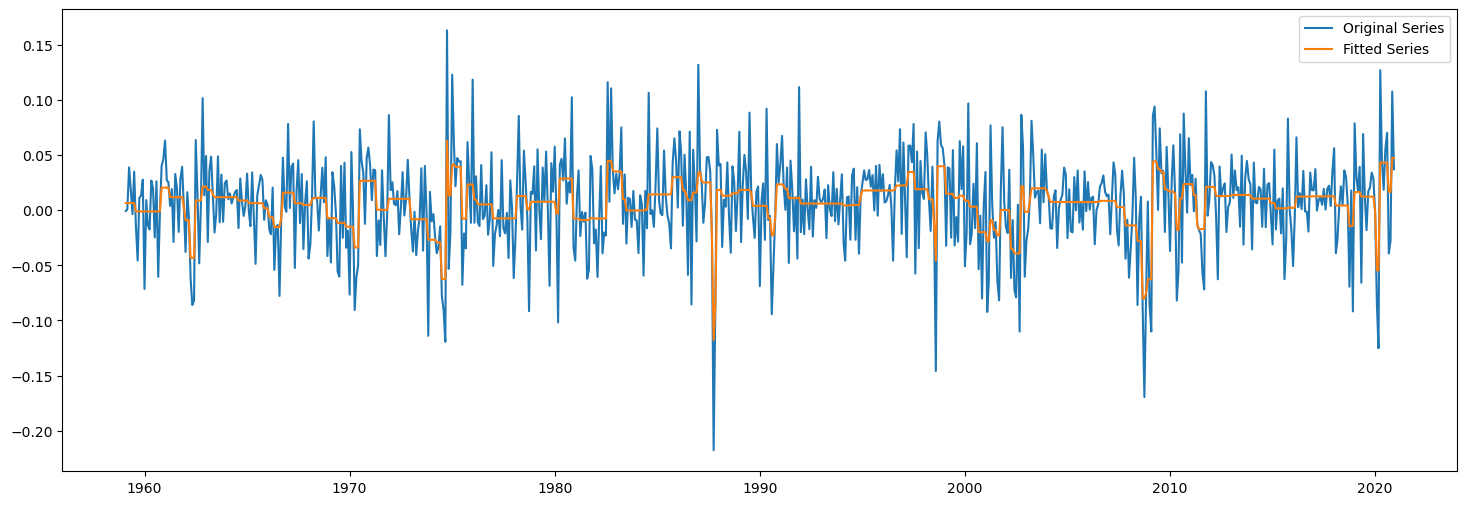

In [6]:
fitted = filter.fit(ret,0.1)

plt.figure(figsize=(18, 6))
plt.plot(ret.index,ret, label='Original Series')
plt.plot(fitted.index,fitted, label='Fitted Series')
plt.legend()

In [7]:
threshold=1e-5
regime = (fitted > threshold).map({True:0,False:1})

dfreturns = pd.DataFrame({'ret': ret.squeeze(), 'wealth': wealth.squeeze(), 'fitted' : fitted.squeeze(), 'regime' : regime.squeeze(),'recession' : df_recession['Regime']})
dfreturns['group'] = (dfreturns['regime'] != dfreturns['regime'].shift()).cumsum()

dfreturns['group_recession'] = (dfreturns['recession'] != dfreturns['recession'].shift()).cumsum()

dfreturns.dropna(inplace = True)
dfreturns.head()

,ret,wealth,fitted,regime,recession,group,group_recession
Date,,,,,,,
1959-02-01,-0.000721,0.999279,0.006473,0.0,0.0,2,1
1959-03-01,0.000541,0.999820,0.006473,0.0,0.0,2,1
1959-04-01,0.038781,1.038593,0.006473,0.0,0.0,2,1
1959-05-01,0.018927,1.058251,0.006473,0.0,0.0,2,1
1959-06-01,-0.003579,1.054463,0.006473,0.0,0.0,2,1


Text(0.5, 1.0, 'Cumulative Performance Over time')

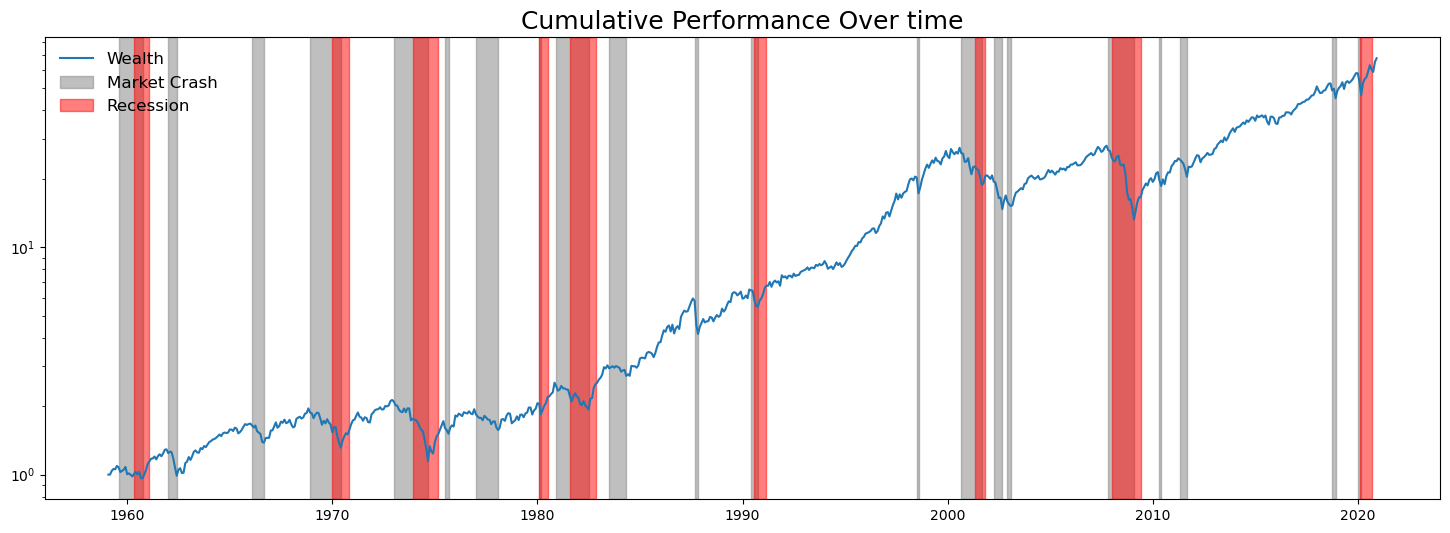

In [8]:
plt.figure(figsize=(18, 6))

plt.plot(dates, wealth, label='Wealth')


#ottengo date crash mercato
crashes = []

for row in dfreturns[dfreturns['regime'] == 1].groupby('group').apply(lambda x: (x.index[0], x.index[-1])).reset_index(drop=True):
    crashes.append((row[0],row[1]))
    
    
#ottengo date recessione
recessions = []
    
for row in dfreturns[dfreturns['recession'] == 1].groupby('group_recession').apply(lambda x: (x.index[0], x.index[-1])).reset_index(drop=True):
    recessions.append((row[0],row[1]))
    
    
for i, data in enumerate(crashes):
    if i == len(crashes) - 1:
        plt.axvspan(data[0],data[1], alpha=0.5, color='grey',label='Market Crash')
    else:
        plt.axvspan(data[0],data[1], alpha=0.5, color='grey')
        
for i, data in enumerate(recessions):
    if i == len(recessions) - 1:
        plt.axvspan(data[0],data[1], alpha=0.5, color='red',label='Recession')
    else:
        plt.axvspan(data[0],data[1], alpha=0.5, color='red')
        
    
    
plt.yscale('log')
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.title('Cumulative Performance Over time', fontsize=18)

Sempre sul sito della fred possiamo ottenere [**Smoothed U.S. Recession Probabilities (RECPROUSM156N)**](https://fred.stlouisfed.org/series/RECPROUSM156N/) che di restituisce la probabilità di essere in recessione degli stati uniti.

Questi dati sono restituiti con un ritardo di 4 mesi.
Lo scopo di questo progetto è provare ad ottenere questi dati al mese corrente, lo faremo usando sempre un dataset messo a disposizione dalla [fred](https://www.stlouisfed.org/research/economists/mccracken/fred-databases).

Questo database contiene 135 features diverse divise in queste macro categorie:

* Produzione e Reddito
* Mercato del lavoro
* Mercato immobiliare
* Consumi ordini e scorte
* Denaro e credito
* Tassi di interesse e scambio
* Prezzi
* Mercato azionario

I dati a disposizione vanno dal 1959 a oggi, useremo i dati fino al 1980 per eseguire il training dei dati il periodo successivo verrà usato per testare le prestazioni dei nostri modelli.

Useremo come treshold per la classificazione il valore 0.5.
Dobbiamo prestare attenzione in quanto il nostro dataset è fortemente sbilanciato abbiamo pù valori di crescita del mercato che di recessione.

Non possiamo utilizzare le metrice classiche di valutazione, per avere metriche migliori potremmo usare:

* La curva ROC una metrica comune per le classi sbilanciate
* Il coefficiente di correlazione di Mattew 

Iniziamo dunque a trattare questo dataset importando i dati.

In [9]:
df_macro = pd.read_csv('data/macro_raw.csv')[:-1] 
df_macro.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN


Notiamo subito una cosa strana la prima riga contiene la dicitura **transform** con dei valori numerici queste sono i dati delle trasformazioni da applicare per rendere stazionario questo valore.
Questo viene descritto nel [documento](./Books/FRED-MD_updated_appendix.pdf)

Come prima cosa analizziamo il numero di valori nan per ogni colonna del dataset.

In [10]:
nan_counts = df_macro.isna().sum()
nan_counts_df = nan_counts.reset_index()
nan_counts_df.columns = ['Columns', 'NaN']
nan_counts_df = nan_counts_df.sort_values(by='NaN', ascending=False).reset_index(drop=True)
nan_counts_df.head(15)

,Columns,NaN
0,ACOGNO,397
1,TWEXAFEGSMTHx,168
2,UMCSENTx,154
3,ANDENOx,109
4,VIXCLSx,42
5,PERMITW,12
6,PERMIT,12
7,PERMITNE,12
8,PERMITMW,12
9,PERMITS,12


Dobbiamo decidere come trattare questi valori imposteremo una soglia di 50 e costruiremo una funzione per eliminare le colonne con un numero troppo elevato di NaN

In [11]:
def remove_variables(df,n):
    # if a variable has more than 'n' NaN values remove it.
    for col in df.columns:
        if df[col].isna().sum() > n:
            print(f"Dropped column {col}")
            df.drop(col, axis=1, inplace=True)
    return df

In [12]:
missing_num = 50
df_clean = remove_variables(df_macro,missing_num)

Dropped column ACOGNO
Dropped column ANDENOx
Dropped column TWEXAFEGSMTHx
Dropped column UMCSENTx


una volta elimnate le colonne procediamo al riempimento con i valori precedenti mediante il metodo ffill e rinominiamo la colonna sasdate come Date

In [13]:
df_clean.fillna(method='ffill', inplace=True) 
df_clean.rename(columns={'sasdate': 'Date'}, inplace=True)

In [14]:
df_clean

,Date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.000000e+00,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.000,6.000,6.00,6.00,6.00,6.00,6.00,6.0000,1.0000
1,1/1/1959,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,...,63.517,18.294,10.152,2.13,2.45,2.04,6476.00,12298.00,84.2043,1.0000
2,2/1/1959,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,...,63.554,18.302,10.167,2.14,2.46,2.05,6476.00,12298.00,83.5280,1.0000
3,3/1/1959,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,...,63.634,18.289,10.185,2.15,2.45,2.07,6508.00,12349.00,81.6405,1.0000
4,4/1/1959,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,...,63.698,18.300,10.221,2.16,2.47,2.08,6620.00,12484.00,81.8099,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,7/1/2024,19988.217,16306.3,120.966,1.529744e+06,710851.00000,102.5192,100.5344,100.2938,101.3583,...,105.316,119.776,127.972,31.20,35.70,27.96,548691.61,930374.96,5278.3525,14.4084
788,8/1/2024,20007.209,16322.1,121.052,1.530317e+06,710038.00000,103.0135,100.9825,100.9803,102.2118,...,105.065,119.653,128.291,31.26,35.81,27.97,551667.22,933066.90,5327.6461,19.6750
789,9/1/2024,20044.142,16333.7,121.690,1.541305e+06,716388.00000,102.5969,100.3826,100.0630,101.9696,...,105.416,119.220,128.682,31.44,36.00,28.11,553347.06,934283.59,5368.5818,17.6597
790,10/1/2024,20128.752,16397.9,121.948,1.539382e+06,720393.00000,102.0854,99.5434,98.9267,101.3127,...,105.474,119.064,129.169,31.55,36.22,28.14,554377.25,937299.96,5407.3304,19.9478


Ora passiamo alla trasformazione dei dati al fine di renderli stazionari

In [15]:
class MacroDataProcess:
    # Stationarity transofrmation
    # Add lag of the features

    def __init__(self,macro_data):
        self.data = macro_data
        self.transformation_codes = None

    def transform(self, df_col, code):
        """
        Transforms each column of dataframe (df_col) according to code
        Transformations for each code are shown in appendix

        Parameters
        ----------
        df_col: pandas dataframe column

        code: int or float
        """
        if code == 1:
            df_col.apply(lambda x: x)
            return df_col
        elif code == 2:
            df_col = df_col.diff()
            return df_col
        elif code == 3:
            df_col = df_col.diff(periods=2)
            return df_col
        elif code == 4:
            df_col = df_col.apply(np.log)
            return df_col
        elif code == 5:
            df_col = df_col.apply(np.log)
            df_col = df_col.diff()
            return df_col
        elif code == 6:
            df_col = df_col.apply(np.log)
            df_col = df_col.diff(periods=2)
            return df_col
        elif code == 7:
            df_col = df_col.pct_change()
            df_col = df_col.diff()
            return df_col

    def stationarity(self):
        """
        Clean macro dataset and perform necessary changes
        """
        # Keep transformation codes for each variable in a dictionary 
        transformation_codes = {}
        df_tmp=pd.DataFrame(columns = self.data.columns)
        for col in self.data.columns:
            df_tmp[col]= self.data[col].iloc[1:] 
            transformation_codes[col] = self.data[col].iloc[0]
        df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])

        self.data=df_tmp
        self.tansformation_codes = transformation_codes
        # Make each feature stationary 
        data_transformed: DataFrame = pd.DataFrame(columns=self.data.columns)
        for col in self.data.columns:
            if col == 'Date':
                data_transformed[col] = self.data[col]
            else:
                data_transformed[col] = self.transform(self.data[col], transformation_codes[col])
        self.data = data_transformed

    def add_lag(self,lag_values):
        for col in self.data.drop(['Date'], axis=1):
            for n in lag_values:
                self.data['{} {}M lag'.format(col, n)] = self.data[col].shift(n).ffill().values
        self.data.dropna(axis=0, inplace=True)
        return self.data
    
    def get_dataframe(self):
        self.data.dropna(axis=0, inplace=True)
        return self.data

In [16]:
transform = MacroDataProcess(macro_data = df_clean)
transform.stationarity()
df_process = transform.get_dataframe()

In [17]:
df_process.to_csv('./data/macro_processed.csv',index=False)

In [18]:
print('MacroFeatures shape:', df_process.shape)
print('Start date: '+ str(df_process.Date.iloc[0])+' End date: '+str(df_process.Date.iloc[-1]))

MacroFeatures shape: (789, 123)
Start date: 1959-03-01 00:00:00 End date: 2024-11-01 00:00:00


Leggiamo anche le etichette di riferimento

In [19]:
df_regime = pd.read_csv('data/recession.csv',parse_dates = ['Date'])

In [20]:
df = df_process.merge(df_regime, on='Date',how='left')

Ora abbiamo i dati con cui poter lavorare iniziamo a creare il dataframe di test e il dataframe di train

In [21]:
split_date = '1983-01-01' # train and test set split date
df_train, df_test = df[df['Date'] < split_date], df[df['Date'] >= split_date]
target_col = 'Regime'
feature_col = df.columns.drop(['Regime', 'Date'])

Iniziamo con il predisporci per la creazione del modello prima creiamo la funzione di valutazione delle metriche

In [22]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [35]:
def error_metrics(y_true,y_pred,y_prob=None):
    """
    Four classification error metrics that will be used to evaluate model performance
    ACC: accuracy (0-1) loss
    QPS: quadratic probability score
    MCC: Matthew's Correlation Coefficient
    AUC: Area under the ROC curve
    """
    mcc = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    mis_rate = (y_true != y_pred).sum() / len(y_true)
    
    err_dict = {
                    'ACC': 1 - mis_rate,
                    'MCC': mcc
               }
    if y_prob is not None:
        roc = roc_auc_score(y_true=y_true, y_score=y_prob)
        err_dict['AUC'] = roc
        
        qps = sum((y_prob - y_true) ** 2) / len(df)
        err_dict['QPS'] = qps

    return err_dict

In [24]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200,400],
    'max_depth': [None, 3, 5, 8, 10, 20],
    'min_samples_split': [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=3)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='matthews_corrcoef')
grid_search.fit(df_train[feature_col], df_train[target_col])

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 8, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='matthews_corrcoef')

In [25]:
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 50}


In [26]:
best_model = grid_search.best_estimator_

In [40]:
y_pred = best_model.predict(df_test[feature_col])
y_prob = best_model.predict_proba(df_test[feature_col])[:, 1]
error_metrics(df_test[target_col],y_pred,y_prob)

{'ACC': 0.9681908548707754,
 'MCC': 0.7637373583159687,
 'AUC': 0.9851241900647949,
 'QPS': 0.03285874226051294}

In [41]:
import pickle

with open('recession_model.pkl', 'wb') as file:
    pickle.dump(model, file)

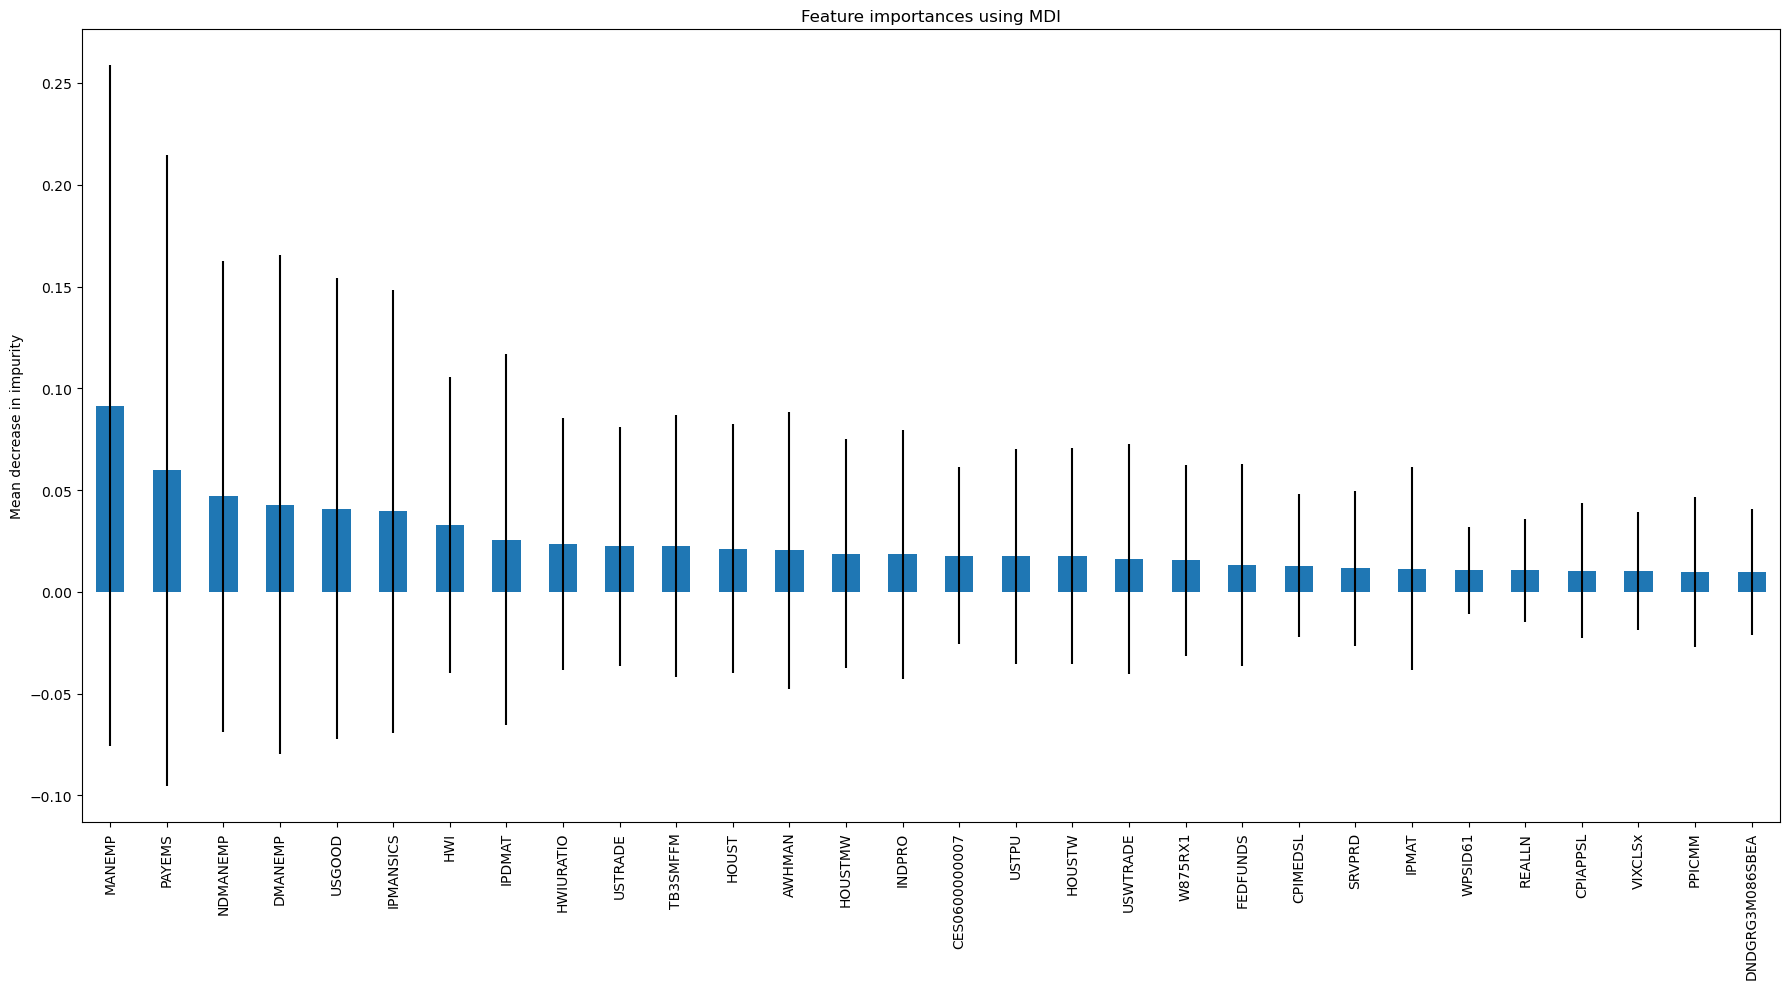

In [52]:
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_col).to_frame('importance')
forest_importances['std'] = std

forest_importances = forest_importances.sort_values(by='importance', ascending=False)[:30]


fig, ax = plt.subplots(figsize=(18, 10))
forest_importances['importance'].plot.bar(yerr=forest_importances['std'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [65]:
columns = ['Date',target_col]
df_rec = df_test[columns].copy()
df_rec['Pred'] = y_pred
df_rec['Prob'] = y_prob
df_rec.set_index('Date', inplace=True)

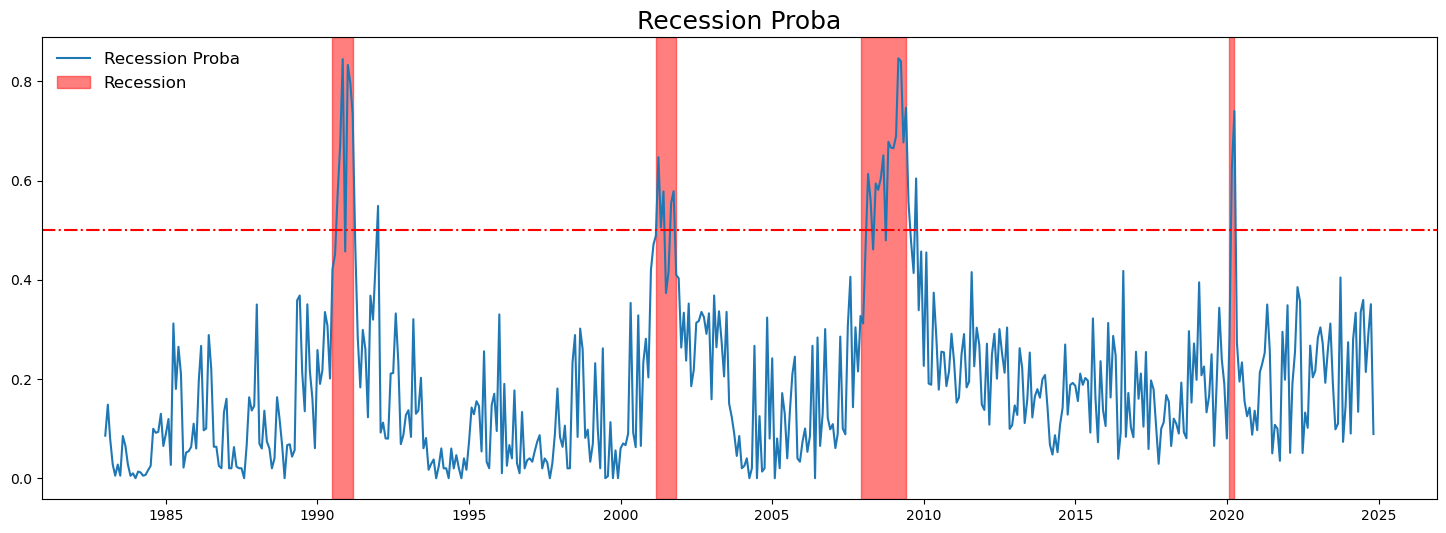

In [76]:
plt.figure(figsize=(18, 6))

plt.plot(df_rec.index, df_rec['Prob'], label='Recession Proba')


#ottengo date crash mercato
recessions = []

df_rec['group'] = (df_rec[target_col] != df_rec[target_col].shift()).cumsum()

for row in df_rec[df_rec[target_col] == 1].groupby('group').apply(lambda x: (x.index[0], x.index[-1])).reset_index(drop=True):
    recessions.append((row[0],row[1]))
    
for i, data in enumerate(recessions):
    if i == len(recessions) - 1:
        plt.axvspan(data[0],data[1], alpha=0.5, color='red',label='Recession')
    else:
        plt.axvspan(data[0],data[1], alpha=0.5, color='red')
        


    
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.title('Recession Proba', fontsize=18)
plt.axhline(y=0.5, color='r', linestyle='-.')